# DC Operating Point Analysis

This notebook demonstrates DC operating point analysis in Pulsim.

## Contents
1. Basic DC Analysis
2. DCAnalysisResult Structure
3. Resistor Networks
4. Voltage Dividers
5. Circuits with Nonlinear Devices

In [1]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

## 1. Basic DC Analysis

DC operating point analysis finds the steady-state solution where all capacitor currents and inductor voltages are zero.

In [2]:
# Simple circuit with voltage source and resistor
ckt = ps.Circuit()
gnd = ckt.ground()

n1 = ckt.add_node("v1")

ckt.add_voltage_source("V1", n1, gnd, 5.0)  # 5V source
ckt.add_resistor("R1", n1, gnd, 1000.0)     # 1kΩ to ground

# Run DC analysis
dc_result = ps.dc_operating_point(ckt)

print("DC Analysis Result:")
print(f"  Success: {dc_result.success}")
print(f"  Strategy: {dc_result.strategy_used}")

if dc_result.success:
    sol = dc_result.newton_result.solution
    print(f"\nNode Voltages:")
    print(f"  V(v1) = {sol[0]:.4f} V")
    print(f"\nExpected: 5.0 V (voltage source)")

DC Analysis Result:
  Success: True
  Strategy: DCStrategy.Direct

Node Voltages:
  V(v1) = 5.0000 V

Expected: 5.0 V (voltage source)


## 2. DCAnalysisResult Structure

The `DCAnalysisResult` contains detailed information about the DC solution.

In [3]:
print("DCAnalysisResult fields:")
print(f"  success:       {dc_result.success}")
print(f"  strategy_used: {dc_result.strategy_used}")

# Newton solver result
nr = dc_result.newton_result
print(f"\nNewtonResult:")
print(f"  status:         {nr.status}")
print(f"  iterations:     {nr.iterations}")
print(f"  final_residual: {nr.final_residual:.2e}")
print(f"  solution size:  {len(nr.solution)}")

DCAnalysisResult fields:
  success:       True
  strategy_used: DCStrategy.Direct

NewtonResult:
  status:         SolverStatus.Success
  iterations:     2
  final_residual: 0.00e+00
  solution size:  2


## 3. Resistor Networks

Analyze resistor network circuits.

In [4]:
# Series resistors
ckt_series = ps.Circuit()
gnd = ckt_series.ground()

n1 = ckt_series.add_node("v1")
n2 = ckt_series.add_node("v2")
n3 = ckt_series.add_node("v3")

ckt_series.add_voltage_source("V1", n1, gnd, 10.0)
ckt_series.add_resistor("R1", n1, n2, 1000.0)  # 1kΩ
ckt_series.add_resistor("R2", n2, n3, 2000.0)  # 2kΩ
ckt_series.add_resistor("R3", n3, gnd, 3000.0) # 3kΩ

dc_series = ps.dc_operating_point(ckt_series)

print("Series Resistors (1kΩ + 2kΩ + 3kΩ):")
print(f"  V_source = 10V")
print(f"  R_total = 6kΩ")
print(f"  I = 10V / 6kΩ = {10/6000*1000:.4f} mA")

if dc_series.success:
    sol = dc_series.newton_result.solution
    print(f"\nSimulated Node Voltages:")
    print(f"  V(v1) = {sol[0]:.4f} V")
    print(f"  V(v2) = {sol[1]:.4f} V (expected: {10*5/6:.4f} V)")
    print(f"  V(v3) = {sol[2]:.4f} V (expected: {10*3/6:.4f} V)")

Series Resistors (1kΩ + 2kΩ + 3kΩ):
  V_source = 10V
  R_total = 6kΩ
  I = 10V / 6kΩ = 1.6667 mA

Simulated Node Voltages:
  V(v1) = 10.0000 V
  V(v2) = 8.3333 V (expected: 8.3333 V)
  V(v3) = 5.0000 V (expected: 5.0000 V)


In [5]:
# Parallel resistors
ckt_parallel = ps.Circuit()
gnd = ckt_parallel.ground()

n1 = ckt_parallel.add_node("v1")

ckt_parallel.add_current_source("I1", gnd, n1, 0.01)  # 10mA
ckt_parallel.add_resistor("R1", n1, gnd, 1000.0)  # 1kΩ
ckt_parallel.add_resistor("R2", n1, gnd, 2000.0)  # 2kΩ

dc_parallel = ps.dc_operating_point(ckt_parallel)

R_parallel = 1 / (1/1000 + 1/2000)
V_expected = 0.01 * R_parallel

print("Parallel Resistors (1kΩ || 2kΩ):")
print(f"  I_source = 10 mA")
print(f"  R_parallel = {R_parallel:.2f} Ω")
print(f"  V_expected = {V_expected:.4f} V")

if dc_parallel.success:
    sol = dc_parallel.newton_result.solution
    print(f"\nSimulated:")
    print(f"  V(v1) = {sol[0]:.4f} V")

Parallel Resistors (1kΩ || 2kΩ):
  I_source = 10 mA
  R_parallel = 666.67 Ω
  V_expected = 6.6667 V

Simulated:
  V(v1) = -6.6667 V


## 4. Voltage Dividers

Classic voltage divider analysis.

In [6]:
def analyze_voltage_divider(V_in, R1, R2):
    """Analyze voltage divider and compare with theory."""
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, V_in)
    ckt.add_resistor("R1", n_in, n_out, R1)
    ckt.add_resistor("R2", n_out, gnd, R2)
    
    dc = ps.dc_operating_point(ckt)
    
    # Theoretical
    V_out_theory = V_in * R2 / (R1 + R2)
    
    if dc.success:
        V_out_sim = dc.newton_result.solution[1]
        error = abs(V_out_sim - V_out_theory)
        return V_out_sim, V_out_theory, error
    return None, V_out_theory, None

# Test various divider ratios
V_in = 12.0
R1_values = [1000, 2000, 3000, 4000]
R2_fixed = 1000

print("Voltage Divider Analysis (V_in = 12V, R2 = 1kΩ):")
print("=" * 60)
print(f"{'R1 (kΩ)':<10} {'Ratio':<10} {'V_theory':<12} {'V_sim':<12} {'Error'}")
print("-" * 60)

for R1 in R1_values:
    v_sim, v_theory, err = analyze_voltage_divider(V_in, R1, R2_fixed)
    ratio = R2_fixed / (R1 + R2_fixed)
    print(f"{R1/1000:<10.0f} {ratio:<10.3f} {v_theory:<12.4f} {v_sim:<12.4f} {err:.2e}")

Voltage Divider Analysis (V_in = 12V, R2 = 1kΩ):
R1 (kΩ)    Ratio      V_theory     V_sim        Error
------------------------------------------------------------
1          0.500      6.0000       6.0000       0.00e+00
2          0.333      4.0000       4.0000       0.00e+00
3          0.250      3.0000       3.0000       0.00e+00
4          0.200      2.4000       2.4000       0.00e+00


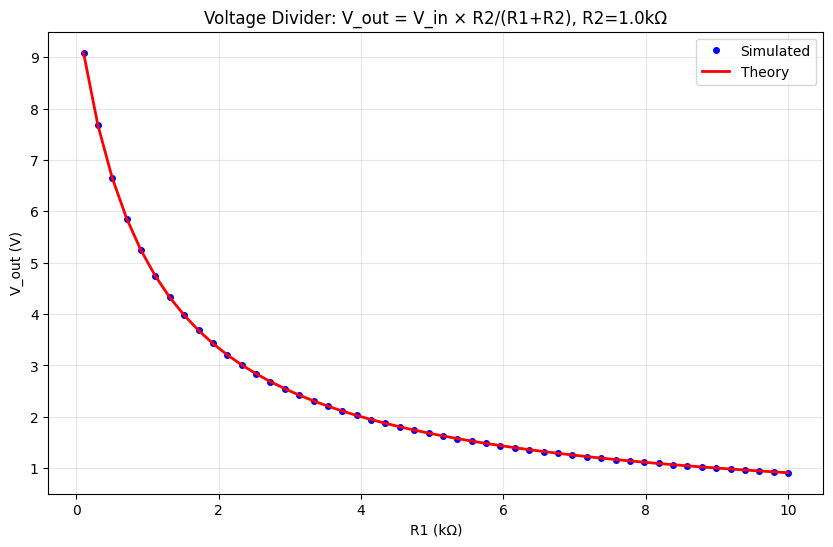

In [7]:
# Plot voltage divider transfer function
R1_sweep = np.linspace(100, 10000, 50)
R2 = 1000
V_in = 10.0

V_out_values = []
for R1 in R1_sweep:
    v_sim, v_theory, _ = analyze_voltage_divider(V_in, R1, R2)
    V_out_values.append(v_sim)

# Theoretical curve
V_out_theory = V_in * R2 / (R1_sweep + R2)

plt.figure(figsize=(10, 6))
plt.plot(R1_sweep/1000, V_out_values, 'bo', markersize=4, label='Simulated')
plt.plot(R1_sweep/1000, V_out_theory, 'r-', linewidth=2, label='Theory')
plt.xlabel('R1 (kΩ)')
plt.ylabel('V_out (V)')
plt.title(f'Voltage Divider: V_out = V_in × R2/(R1+R2), R2={R2/1000}kΩ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Circuits with Nonlinear Devices

DC analysis with diodes and switches.

In [8]:
# Diode circuit
ckt_diode = ps.Circuit()
gnd = ckt_diode.ground()

n_in = ckt_diode.add_node("v_in")
n_out = ckt_diode.add_node("v_out")

ckt_diode.add_voltage_source("Vin", n_in, gnd, 5.0)
ckt_diode.add_diode("D1", n_in, n_out)  # Forward biased
ckt_diode.add_resistor("R1", n_out, gnd, 1000.0)

dc_diode = ps.dc_operating_point(ckt_diode)

print("Diode Circuit (Forward Biased):")
if dc_diode.success:
    sol = dc_diode.newton_result.solution
    v_in = sol[0]
    v_out = sol[1]
    v_diode = v_in - v_out
    i_diode = v_out / 1000 * 1000  # mA
    
    print(f"  V_in = {v_in:.4f} V")
    print(f"  V_out = {v_out:.4f} V")
    print(f"  V_diode = {v_diode:.4f} V")
    print(f"  I_diode = {i_diode:.4f} mA")

Diode Circuit (Forward Biased):
  V_in = 5.0000 V
  V_out = 5.0000 V
  V_diode = 0.0000 V
  I_diode = 5.0000 mA


In [9]:
# Switch circuit - compare open vs closed
def analyze_switch_circuit(switch_closed):
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n1 = ckt.add_node("v1")
    n2 = ckt.add_node("v2")
    
    ckt.add_voltage_source("V1", n1, gnd, 10.0)
    ckt.add_switch("SW1", n1, n2, closed=switch_closed)
    ckt.add_resistor("R1", n2, gnd, 1000.0)
    
    dc = ps.dc_operating_point(ckt)
    
    if dc.success:
        return dc.newton_result.solution
    return None

print("Switch Circuit Analysis:")
print("=" * 40)

for closed in [True, False]:
    state = "CLOSED" if closed else "OPEN"
    sol = analyze_switch_circuit(closed)
    
    print(f"\nSwitch {state}:")
    if sol is not None:
        print(f"  V(v1) = {sol[0]:.4f} V")
        print(f"  V(v2) = {sol[1]:.4f} V")
        
        if closed:
            print(f"  Current = {sol[1]/1000*1000:.4f} mA")
        else:
            print(f"  Current ≈ 0 mA (switch open)")

Switch Circuit Analysis:

Switch CLOSED:
  V(v1) = 10.0000 V
  V(v2) = 10.0000 V
  Current = 10.0000 mA

Switch OPEN:
  V(v1) = 10.0000 V
  V(v2) = 0.0000 V
  Current ≈ 0 mA (switch open)


## Summary

### DC Analysis API

```python
# Basic DC analysis
result = ps.dc_operating_point(circuit)

# With custom configuration
config = ps.DCConvergenceConfig()
config.newton.max_iterations = 100
result = ps.dc_operating_point(circuit, config)

# Check result
if result.success:
    solution = result.newton_result.solution
    for i, v in enumerate(solution):
        print(f"Node {i}: {v:.4f} V")
```

### Key Points

- DC analysis finds the steady-state operating point
- Capacitors act as open circuits (no current)
- Inductors act as short circuits (no voltage drop)
- Nonlinear devices (diodes, switches) are handled iteratively
- Use convergence aids for difficult circuits

**Next:** [Benchmarks](10_benchmarks.ipynb)

In [10]:
# Test cell-12 logic
R_crit = 2 * np.sqrt(1e-3 / 1e-6)
R_test = R_crit * 0.2
L_rlc = 1e-3
C_rlc = 1e-6
V_rlc = 1.0

rlc_analytical = ps.RLCAnalytical(R_test, L_rlc, C_rlc, V_rlc, V_initial=0.0, I_initial=0.0)

print(f"RLCAnalytical:")
print(f"  Damping ratio ζ = {rlc_analytical.zeta():.3f}")
print(f"  Natural frequency ω₀ = {rlc_analytical.omega_0():.1f} rad/s")
print(f"  Damping coefficient α = {rlc_analytical.alpha():.1f}")
print(f"  Damping type: {rlc_analytical.damping_type()}")

RLCAnalytical:
  Damping ratio ζ = 0.200
  Natural frequency ω₀ = 31622.8 rad/s
  Damping coefficient α = 6324.6
  Damping type: RLCDamping.Underdamped


In [11]:
# Test notebook 07 cells

# Cell 3 - NewtonOptions
opts = ps.NewtonOptions()
print("NewtonOptions attributes:")
print(dir(opts))

NewtonOptions attributes:
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_conduit_v1_', 'auto_damping', 'check_per_variable', 'initial_damping', 'max_iterations', 'min_damping', 'num_branches', 'num_nodes', 'tolerances', 'track_history']


In [12]:
# Check NewtonOptions values
opts = ps.NewtonOptions()
print("NewtonOptions default values:")
print(f"  max_iterations: {opts.max_iterations}")
print(f"  initial_damping: {opts.initial_damping}")
print(f"  min_damping: {opts.min_damping}")
print(f"  auto_damping: {opts.auto_damping}")
print(f"  track_history: {opts.track_history}")
print(f"  check_per_variable: {opts.check_per_variable}")
print(f"  num_nodes: {opts.num_nodes}")
print(f"  num_branches: {opts.num_branches}")

# Check tolerances
print(f"\nTolerances:")
tol = opts.tolerances
print(f"  type: {type(tol)}")

NewtonOptions default values:
  max_iterations: 50
  initial_damping: 1.0
  min_damping: 0.01
  auto_damping: True
  track_history: True
  check_per_variable: True
  num_nodes: 0
  num_branches: 0

Tolerances:
  type: <class 'pulsim._pulsim.Tolerances'>
